# 0. Импорты и определения

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Функция для создания боксплотов с разбивкой по категориям

def create_boxplots(df, x, y, order=None, title='', xlabel='', ylabel='', figsize=(14, 6)):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(data=df, 
                x=x, 
                y=y,
                order=order,
                color=single_color,
                ax=ax)
    ax.set(title=title, 
           xlabel=xlabel, 
           ylabel=ylabel)
    plt.show();

In [4]:
# Функция для создания гистограммы

def create_histplot(df, x, bins=10, discrete=False, title='', xlabel='', ylabel='', figsize=(14, 6)):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=figsize)
    sns.histplot(data=df, 
                 x=x, 
                 bins=bins, 
                 discrete=discrete,
                 color=single_color,
                 ax=ax)
    ax.set(title=title, 
           xlabel=xlabel, 
           ylabel=ylabel)
    plt.show();

In [5]:
# Функция для создания барчарта

def create_barchart(df, x, y, xlabel, ylabel, title, vline_x=0, figsize=(14, 6)): 
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(data=df, 
                x=x, 
                y=y,
                color=single_color,
                ax=ax)
    ax.set(title=title, 
           xlabel=xlabel, 
           ylabel=ylabel)
    if vline_x != 0:       
        plt.axvline(x=vline_x, 
                    color = 'darkgrey', 
                    linewidth=2, 
                    linestyle='dotted')
    plt.show();

In [6]:
# Функция для расчета затрат клиентов

def calculate_cost(calls_df, tariff_details):

    # Считаем количество операторов у клиента в каждом месяце
    operators_stat = (
        calls_df.groupby(['user_id', 'month'],
                     as_index=False)
        .agg({'operator_id': pd.Series.nunique})
        .rename(columns={'operator_id': 'operator_count'})
    )
    
    # Считаем продолжительность звонков
    calls_stat = (
        calls_df.groupby(['tariff_plan',
                          'user_id',
                          'month',
                          'direction',
                          'internal'],
                         as_index=False)
        .agg({'total_call_duration_min': 'sum'})
    )
    
    merged_df = operators_stat.merge(calls_stat, 
                                     on=['user_id', 'month'], 
                                     how='left')
    # Количество минут сверх лимита
    merged_df['over_limit_minutes'] = (
        merged_df.loc[(merged_df['direction']=='out')
                      & (merged_df['internal']==True),
                      'total_call_duration_min'] -
        tariff_details['outgoing_internal_limit']
    )
    
    # Все, что меньше или равно 0 заменим на 0
    merged_df.loc[(merged_df['over_limit_minutes']<=0)
                  | (merged_df['over_limit_minutes'].isna()), 
                 'over_limit_minutes'] = 0
    
    # Плата за исходящие внутренние сверх лимита
    merged_df['over_limit_cost'] = (
        merged_df['over_limit_minutes'] * 
        tariff_details['outgoing_internal_price']
    )
    
    # Плата за исходящие внешние
    
    merged_df['outgoing_external_cost'] = (
        merged_df.loc[(merged_df['direction']=='out')
                      & (merged_df['internal']==False),
                      'total_call_duration_min'] *  
        tariff_details['outgoing_external_price']
    )
    
    # Все, что меньше или равно 0 заменим на 0
    merged_df.loc[(merged_df['outgoing_external_cost']<=0)
                  | (merged_df['outgoing_external_cost'].isna()), 
                 'outgoing_external_cost'] = 0
    
    # Плата за операторов
    merged_df['operators_cost'] = (
        merged_df['operator_count'] * tariff_details['operator_price']
    )
    
    # Ежемесячная плата
    merged_df['month_cost'] = tariff_details['price_month']
    
    # Результирующий датафрейм
    result_df = (
        merged_df.groupby(['user_id',
                           'month'],
                          as_index=False)
        .agg({'over_limit_cost': 'max',
              'outgoing_external_cost': 'max',
              'operators_cost': 'max',
              'month_cost': 'max'})
    )
    
    #Полная стоимость
    result_df['total_cost'] = (
        result_df[['over_limit_cost',
                   'outgoing_external_cost',
                   'operators_cost',
                   'month_cost']].sum(axis=1)
        .astype(float)
    )
    
    result_df['tariff_plan'] = tariff_details['tariff_plan']
    
    return result_df

In [7]:
# Функция для подсчета статистики в разрезе измерений

def get_stat(df, dimensions, values, aggfunc):
    return df.groupby(by=dimensions, as_index=False).agg({values: aggfunc})

In [8]:
single_color = '#1f78b4'
sns.set_style('darkgrid')

# 1. Загрузка и предобработка данных
На этом этапе проекта выполним следующие шаги:
- загрузим имеющиеся данные и изучим основную информацию о датасетах
- проверим наличие пропусков и определим стратегию их обработки
- проверим корректность типов данных
- проверим наличие дубликатов
- проверим наличие аномалий и определим стратегию их обработки

## 1.1. Загрузка данных и основная информация

In [9]:
calls_raw = pd.read_csv()
clients_raw = pd.read_csv()

In [10]:
calls_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [11]:
calls_raw.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


Датасет с данными о звонках содержит 53902 записи. 

В столбцах `internal` и `operator_id` есть пропуски. 

Есть проблемы с типами данных:
- столбец `date` имеет тип object, хотя хранит в себе дату
- столбец `internal` имеет тип object, хотя хранит в себе булевы значения
- столбец `operator_id` имеет тип float, хотя хранит в себе идентификаторы типа int

In [12]:
clients_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [13]:
clients_raw.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


Датасет с данными о клиентах содержит 732 записи. 

Пропусков нет. 

Есть проблемы с типами данных: столбец `date_start` имеет тип object, хотя хранит в себе дату. 

## 1.2. Обработка пропусков

Выведем количество пропусков в столбцах `internal` и `operator_id` в процентном отношении.

In [14]:
round(100 * calls_raw[['internal', 'operator_id']].isna().mean(), 2)

internal        0.22
operator_id    15.16
dtype: float64

Доля пропусков в столбце `internal` составляет 0.22% от всех записей, а доля пропусков в `operator_id` равна 15.16% от всех записей.

Учитывая специфику задачи, а именно то, что нам необходимо рассчитать затраты клиентов, и в этих расчетах нам необходимы столбцы `internal` и `operator_id`, мы не можем удалять строки с пропусками. Заполнять эти пропуски тоже не будем: восстановить корректные значения по другим столбцам сложно и может привести к ошибкам в последующих расчетах.

## 1.3. Корректировка типов данных

In [15]:
calls = calls_raw.copy()
clients = clients_raw.copy()

In [16]:
calls['date'] = pd.to_datetime(calls['date']).dt.date.astype('datetime64[ns]')
calls['internal'] = calls['internal'].astype('boolean')
calls['operator_id'] = calls['operator_id'].astype('Int64')

clients['date_start'] = pd.to_datetime(clients['date_start'])

## 1.4. Обработка дубликатов

Проверим на наличие полных дубликатов.

In [18]:
calls.duplicated().agg(['sum','mean'])

sum     4900.000000
mean       0.090906
dtype: float64

В датасете нашлось 4900 дублированных строк, это 9.09% всех данных. Дубликаты приведут к неправильным результатам расчетов, нам необходимо их удалить.

In [19]:
calls = calls.drop_duplicates().reset_index(drop=True)
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49002 entries, 0 to 49001
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 49002 non-null  datetime64[ns]
 2   direction            49002 non-null  object        
 3   internal             48892 non-null  boolean       
 4   operator_id          41546 non-null  Int64         
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
dtypes: Int64(1), bool(1), boolean(1), datetime64[ns](1), int64(4), object(1)
memory usage: 2.8+ MB


После удаления дубликатов в датасете осталось 49002 записи.

In [20]:
clients[clients.duplicated()]

,user_id,tariff_plan,date_start


В датасете с данными о клиентах дубликатов нет.

## 1.5. Проверка на наличие аномалий в данных

На этом этапе мы проверим, что данные согласуются со здравым смыслом и предметной областью:

- проверим, что даты звонков согласуются с датами регистрации клиентов
- проверим, что нет клиентов без операторов
- что длительность звонков с учетом времени ожидания не меньше длительности звонка
- проверим, что за сутки отдельный оператор не наговаривает больше 24 часов (учитываем, что `operator_id` - это необязательно физический отдельный человек, а просто рабочее место, на котором могут работать разные люди). 

### 1.5.1. Клиенты и даты регистрации

Найдем для каждого клиента разницу между датой регистрации и датой первого звонка.

Предвариательно объединим датафреймы в один, чтобы иметь в нем всю нужную для расчетов информацию.

In [21]:
data = calls.merge(clients, on='user_id', how='left')

In [22]:
dates_check_df = (
    data.groupby(['user_id', 'date_start'],
                 as_index=False)['date']
    .min()
    .assign(date_diff=lambda x: x['date']-x['date_start'])
)

dates_check_df['date_diff'].min()

Timedelta('0 days 00:00:00')

Минимальная разница между датой регистрациии и датой звонка равна 0 дней, т.е. клиент начал пользоваться услугами сразу в день регистрации. Аномалий в датах не обнаружено.

### 1.5.2. Клиенты без операторов

Подсчитаем количество операторов у каждого клиента и выделим тех, у кого это количество равно нулю.

In [23]:
operator_stat = (
    data.groupby(['user_id'], as_index=False)['operator_id']
    .nunique()
    .rename(columns={'operator_id': 'operator_count'})
)

In [24]:
users_wo_operators = operator_stat.loc[operator_stat['operator_count']==0, 'user_id']
users_wo_operators.shape[0]

17

Обнаружилось 17 клиентов без операторов. Посмотрим на их данные по звонкам.

In [25]:
data.loc[data['user_id'].isin(users_wo_operators)].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
5973,166554,2019-08-09,in,True,<NA>,True,2,0,8,B,2019-08-08
6694,166584,2019-08-16,in,False,<NA>,True,2,0,4,C,2019-08-09
20924,167077,2019-09-06,in,False,<NA>,True,1,0,2,B,2019-08-30
20925,167077,2019-09-07,in,False,<NA>,True,1,0,1,B,2019-08-30
20926,167077,2019-09-09,in,False,<NA>,True,1,0,2,B,2019-08-30


In [26]:
data.loc[data['user_id'].isin(users_wo_operators), 'call_duration'].max()

0

In [27]:
data.loc[data['user_id'].isin(users_wo_operators), 'is_missed_call'].unique()

array([ True])

Очевидно, что клиенты без операторов не отвечают на звонки, и для них `call_duration` будет равна нулю, а признак `is_missed_call` всегда True. 

Отсутствие операторов и отвеченных звонков будем считать одним из признаков неактивного клиента. Эти клиенты не удаляются, в расчете выручки они будут учитываться как неактивные. То есть, выручка с них посчитается, но они не попадут в список тех, кому мы будем оптимизировать тариф.

### 1.5.3. Если `call_duration` больше 0, то звонок засчитан в `calls_count`

Проверим, что нет случаев, когда звонок есть (судя по `call_duration`, а в `calls_count` его не засчитали).

In [28]:
data.loc[data['call_duration'] > 0, 'calls_count'].min()

1

Минимальное количество засчитанных звонков равно 1. Это верно.

### 1.5.4. Длительность звонков меньше, чем длительность со временем ожидания

In [29]:
data[data['total_call_duration'] < data['call_duration']]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start


Здесь все верно.

### 1.5.5.  Длительность звонков одного оператора не превышает 1440 минут в день

Рассчитаем длительность звонков в минутах и проверим, что для одного оператора суммарная дневная длительность не превышает 24\*60 минут.

In [30]:
data['call_duration_min'] = data['call_duration'] / 60
data['total_call_duration_min'] = data['total_call_duration'] / 60

data.rename(columns={'call_duration': 'call_duration_sec', 
                     'total_call_duration': 'total_call_duration_sec'},
           inplace=True)

In [31]:
operator_calls_duration = (
    data.groupby(['operator_id', 'date'], 
             as_index=False)
    .agg({'call_duration_min': 'sum',
          'total_call_duration_min': 'sum'})
)

In [32]:
operator_calls_duration.query('call_duration_min > 1440')

,operator_id,date,call_duration_min,total_call_duration_min
824,885876,2019-09-02,1524.116667,2106.933333
825,885876,2019-09-03,1478.500000,2212.616667
826,885876,2019-09-04,1567.583333,2112.050000
827,885876,2019-09-05,1855.116667,2260.583333
828,885876,2019-09-06,1492.316667,1914.683333
831,885876,2019-09-09,2042.016667,2680.433333
833,885876,2019-09-11,1928.366667,2490.233333
834,885876,2019-09-12,2111.933333,2563.216667
835,885876,2019-09-13,1664.883333,2124.700000
839,885876,2019-09-17,1686.050000,2508.100000


In [33]:
data.query('operator_id == 885876')['user_id'].unique()

array([166582])

Есть оператор, у которого длительность звонков за день превышает 24 часа. Посмотрим подробнее на данные по этому оператору.

In [34]:
operator_stat = (
    data.query('operator_id == 885876').groupby('date', 
                                                as_index=False)['call_duration_min']
    .sum()
)
operator_stat['call_duration_min'].describe()

count      97.000000
mean      749.820103
std       706.120874
min         0.000000
25%        99.500000
50%       521.283333
75%      1353.950000
max      2416.766667
Name: call_duration_min, dtype: float64

Для этого оператора нашлось 97 записей, в среднем он разговаривает 749 минут в день (медианное время 521, значительно ниже среднего). Максимальная дневная длительность звонка составила 2416 минут - это 40 с лишним часов.

Выведем график зависимоти длительности звонков этого оператора от даты:

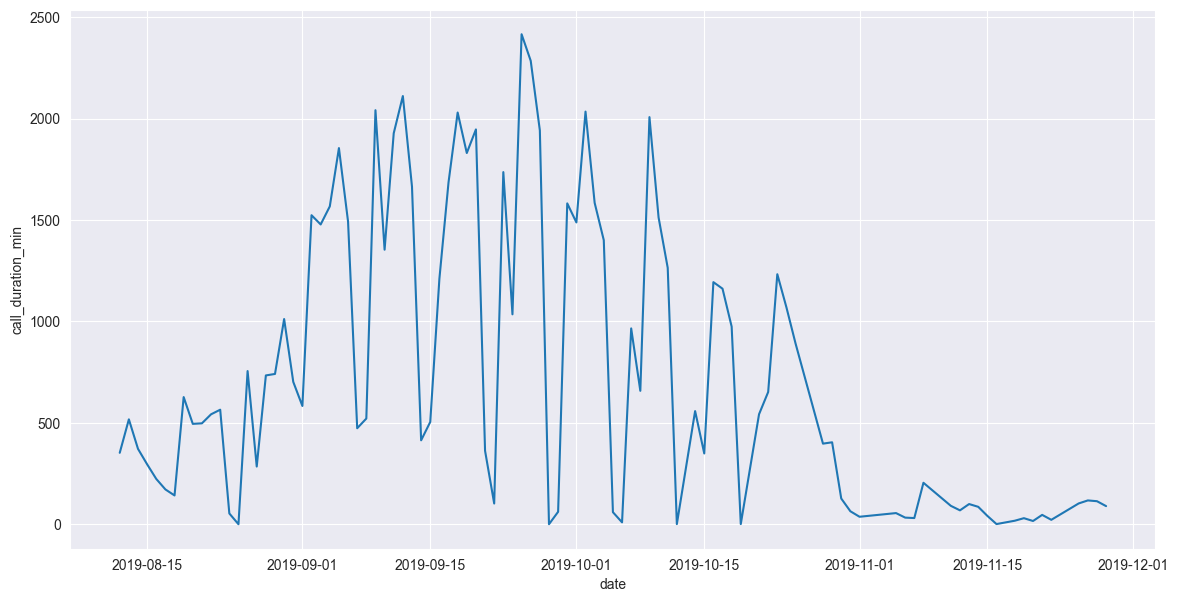

In [35]:
fig, ax = plt.subplots(figsize=(14,7))

sns.lineplot(data=operator_stat, 
             x='date', 
             y='call_duration_min',
             ax=ax);

Найдем клиента, у которого работает этот оператор и проверим остальных его операторов.

In [36]:
data.query('operator_id == 885876')['user_id'].unique()

array([166582])

In [37]:
anomaly_user_stat = (
    data.query('user_id == 166582')
    .groupby(['date', 'operator_id'], 
             as_index=False)['call_duration_min']
    .sum()
)
anomaly_user_stat['operator_id'] = anomaly_user_stat['operator_id'].astype(str)

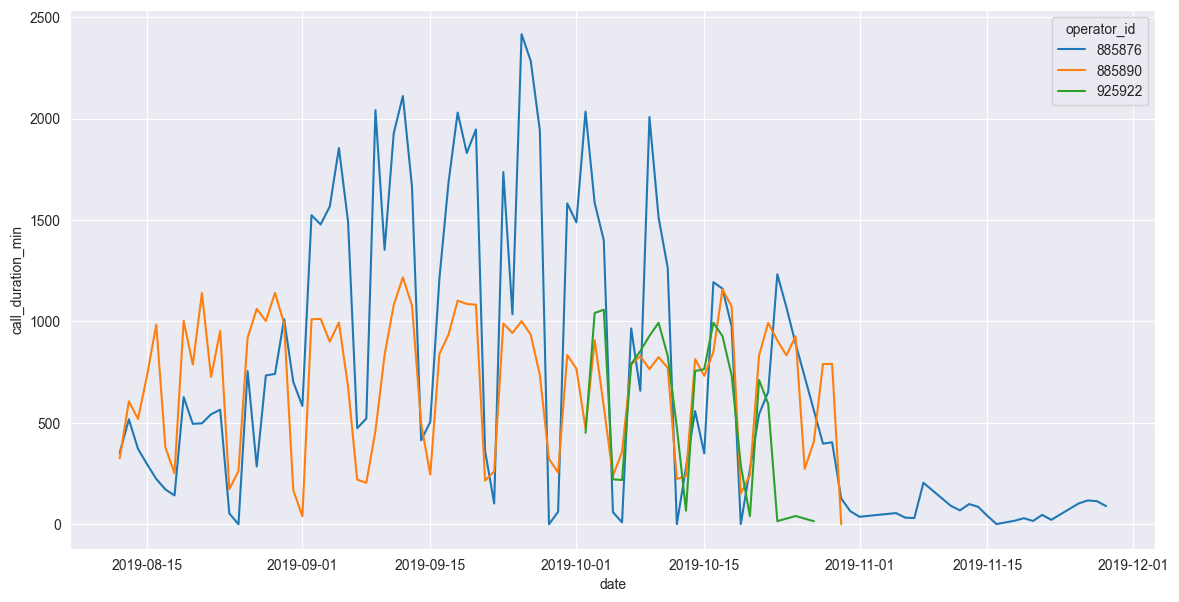

In [38]:
fig, ax = plt.subplots(figsize=(14,7))
sns.lineplot(data=anomaly_user_stat, 
             x='date', 
             y='call_duration_min', 
             hue='operator_id',
             ax=ax);

Кажется, что по остальным операторам такой проблемы нет, их звонки выглядят равномерными и не превышают разумных значений. Видимо, искажены только данные по оператору 885876 и только за сентябрь-октябрь. Возможно, произошел какой-то технический сбой и под одной учеткой работали несколько операторов.

Мы не можем удалить только этого оператора для клиента, т.к. это исказит расчет стоимости связи. Поэтому из анализа придется исключить самого клиента.

In [39]:
data = data.query('user_id != 166582')
data.reset_index(drop=True, inplace=True)
data.shape

(48282, 13)

## 1.6. Дополнительные столбцы

Здесь мы добавим столбцы, которые будут нам полезны в дальнейшем анализе и расчетах.

In [40]:
data['month'] = data['date'].dt.month
data['month_name'] = data['date'].dt.month_name()

In [41]:
data['user_id'].nunique()

306

# 2. Исследовательский анализ данных

- анализ количества клиентов и их тарифов
- анализ звонков клиентов: их количества в разных разрезах (тариф, внутренние/внешние, входящие/исходящие) и во времени
- анализ звонков клиентов: их длительности в разных разрезах (тариф, внутренние/внешние, входящие/исходящие) и во времени
- анализ количества операторов клиентов (по тарифам и по месяцам)
- выделение группы активных клиентов

## 2.1. Анализ количества клиентов

### 2.1.1 По тарифам
 
 Посчитаем, сколько у нас клиентов на каждом из тарифов.

In [42]:
tariffs_stat = data.groupby('tariff_plan', as_index=False)['user_id'].nunique()

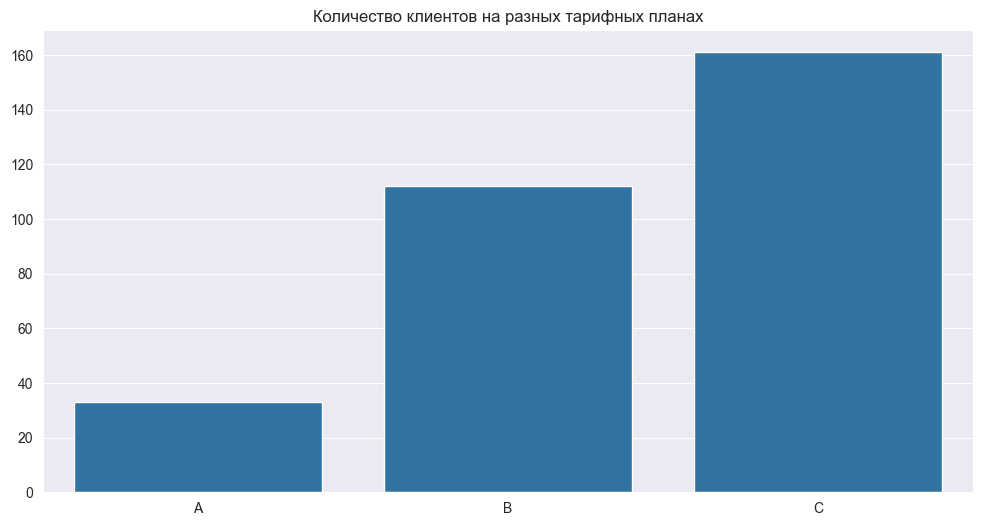

In [43]:
create_barchart(tariffs_stat, 
                x='tariff_plan', 
                y='user_id', 
                xlabel='', 
                ylabel='', 
                title='Количество клиентов на разных тарифных планах',
                figsize=(12,6))

Самый популярный тариф - тариф C, на нем 161 клиент. Дальше идет тариф B со 112 клиентами. Наименее популярен тариф A, на нем всего 33 клиента.

### 2.1.2. По количеству активных месяцев работы

In [44]:
month_stat = get_stat(get_stat(data, 
                               'user_id', 
                               'month', 
                               pd.Series.nunique), 
                      'month', 
                      'user_id', 
                      'count')
month_stat.rename(columns={'month': 'months_count',
                           'user_id': 'users_count'},
                 inplace=True)
month_stat

,months_count,users_count
0,1,39
1,2,117
2,3,85
3,4,65


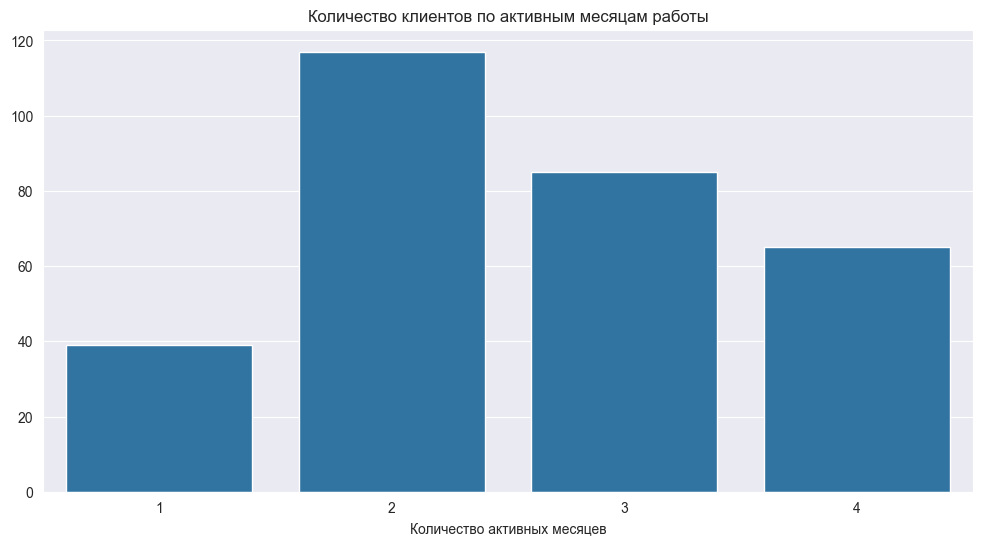

In [45]:
create_barchart(month_stat, 
                x='months_count', 
                y='users_count', 
                xlabel='Количество активных месяцев', 
                ylabel='', 
                title='Количество клиентов по активным месяцам работы',
                figsize=(12,6))

Видим, что самое большое количество клиентов (117) активно пользовалось услугами в течение 2 из 4 прошедших месяцев. Всего 65 клиентов были активны на протяжении всех 4 месяцев, 85 клиентов - на протяжении 3 месяцев.
39 клиентов работают с заказчиком лишь 1 месяц.

В дальнейшем при анализе расходов, будет разумно не учитывать клиентов, которые работают 1 или 2 месяца, т.к. мы не сможем достоверно понять, переплачивают они или нет, слишком мало данных.

## 2.2. Анализ количества звонков клиентов

Здесь мы агрегируем данные за месяц и посмотрим на них в целом, а также в следующих разрезах:

- тариф
- внутренние/внешние звонки
- входящие/исходящие звонки
- различия по месяцам

### 2.2.1. Общая статистика

In [46]:
calls_stat = get_stat(data, 
                      ['user_id', 'tariff_plan', 'month_name'], 
                      'calls_count', 
                      'sum')
calls_stat['calls_count'].describe()

count      788.000000
mean       840.366751
std       4074.355821
min          1.000000
25%         12.750000
50%         66.000000
75%        408.000000
max      71222.000000
Name: calls_count, dtype: float64

Выведем распредление в виде гистограммы. Ограничим количество звонков 1000, чтобы выбросы не искажали картину.

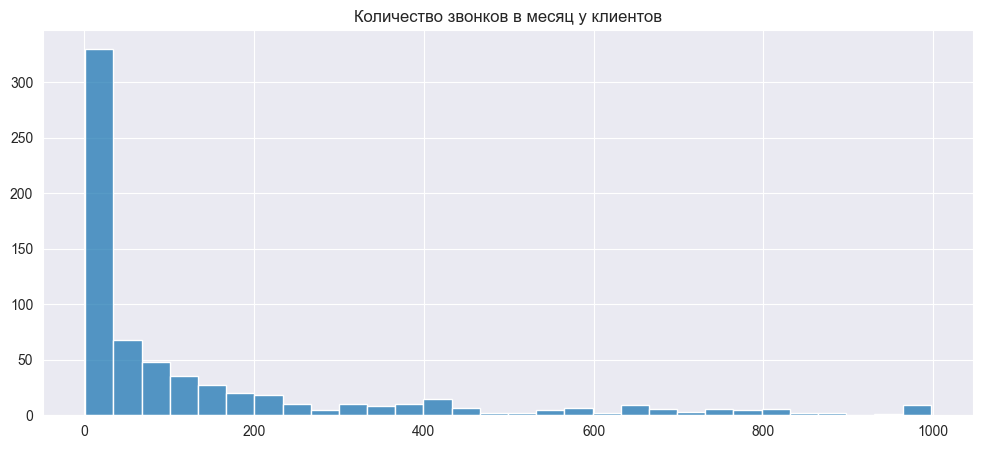

In [47]:
create_histplot(calls_stat.query('calls_count<1000'), 
                x='calls_count', 
                bins=30, 
                title='Количество звонков в месяц у клиентов', 
                xlabel='', 
                ylabel='', 
                figsize=(12, 5))

Видим, что в распределении количества звонков много выбросов, среднее значение (840) сильно отличается от медианы (66). Большинство клиентов укладываются в 408 звонков в месяц, но есть длинный хвост с количеством звонков вплоть до 71222 в месяц.

### 2.2.2. Статистика по тарифам

Посмотрим на распределение количества звонков на разных тарифах.

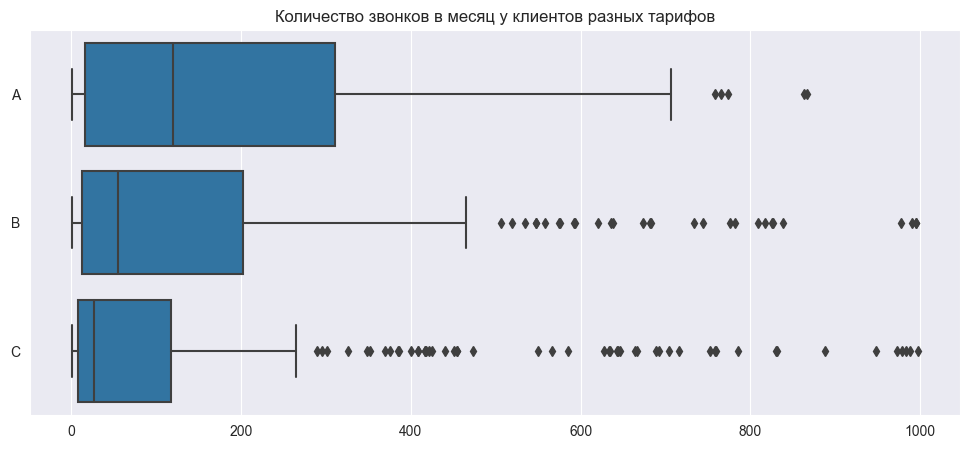

In [48]:
create_boxplots(calls_stat.query('calls_count<1000'), 
                x='calls_count', 
                y='tariff_plan', 
                order=['A', 'B', 'C'],
                title='Количество звонков в месяц у клиентов разных тарифов', 
                xlabel='', 
                ylabel='', 
                figsize=(12, 5))

На тарифе A среднее количество звонков составляет 3316, а медиана 150. На тарифе B среднее количество звонков составляет 565, медиана 96. На тарифе C среднее 496, медиана 38. Получается, что клиенты тарифа звонят чаще, чем клиенты тарифов B и C.

Для всех тарифов разница между средним и медианой велика, и на боксплотах мы видим, как много выбросов в распределениях.

### 2.2.3. Статистика по внутренним и внешним звонкам

Посмотрим на распределение количества внутренних и внешних звонков.

In [49]:
internal_calls_stat = get_stat(data[data['internal'].notna()],
                               ['user_id', 'month_name', 'internal'],
                               'calls_count',
                               'sum')

internal_calls_stat['internal'] = (
    internal_calls_stat['internal'].astype(bool)
    .replace({True: 'Internal',
              False: 'External'})
)

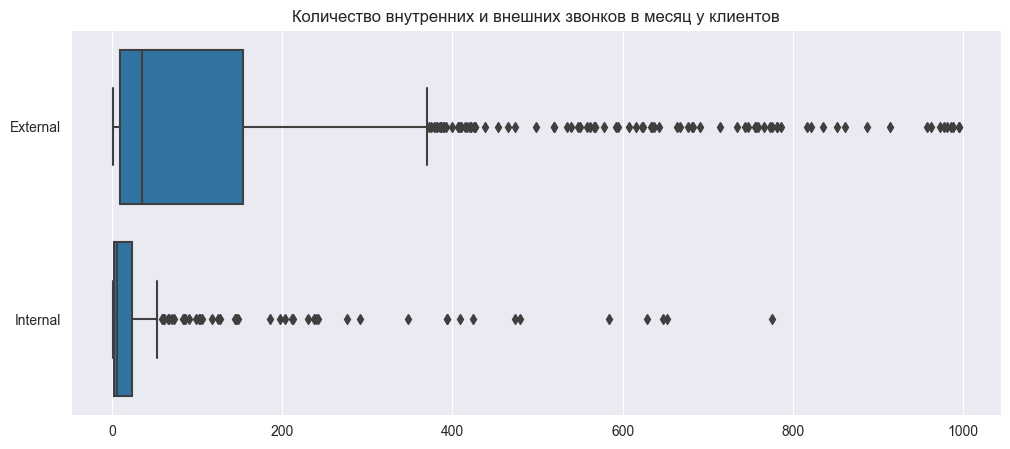

In [50]:
create_boxplots(internal_calls_stat.query('calls_count<1000'), 
                x='calls_count', 
                y='internal', 
                title='Количество внутренних и внешних звонков в месяц у клиентов', 
                xlabel='', 
                ylabel='', 
                figsize=(12, 5))

По внутренним звонкам среднее значение равно 44, медиана 5. По внешним звонкам среднее значение равно 822, а медиана 61. Очевидно, клиенты чаще звонят за пределы компании, чем пользуются внутренней связью. 

### 2.2.4. Статистика по входящим и исходящим звонкам

Посмотрим на распределение количества входящих и исходящих звонков.

In [51]:
direction_calls_stat = get_stat(data,
                               ['user_id', 'month_name', 'direction'],
                               'calls_count',
                               'sum')

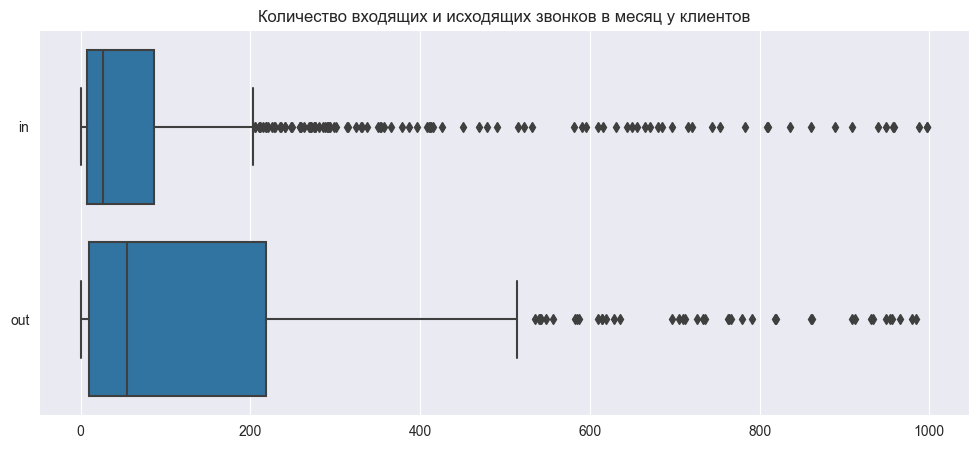

In [52]:
create_boxplots(direction_calls_stat.query('calls_count<1000'), 
                x='calls_count', 
                y='direction', 
                title='Количество входящих и исходящих звонков в месяц у клиентов', 
                xlabel='', 
                ylabel='', 
                figsize=(12, 5))

По входящим звонкам среднее значение 244, медиана 28. По исходящим звонкам среднее значение 921, медиана 96. Чаще операторы сами звонят, чем принимают входящие звонки.

### 2.2.6. Динамика по месяцам

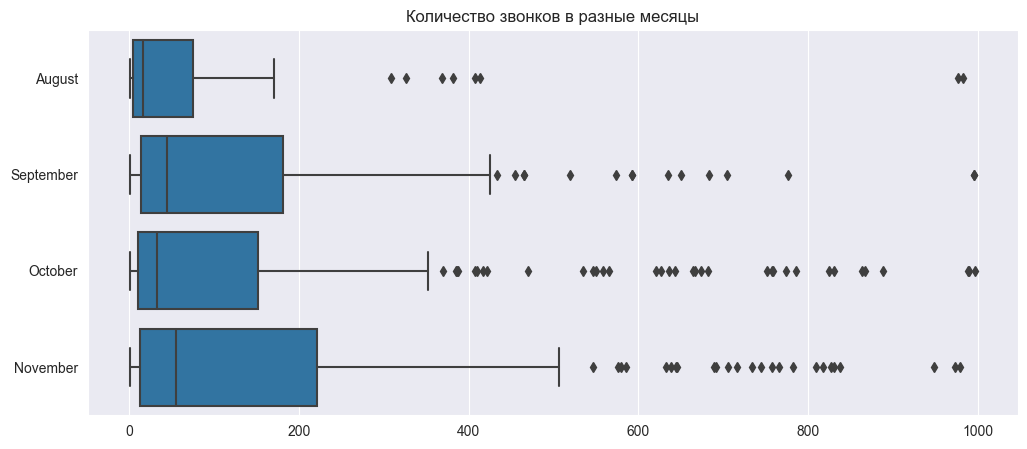

In [53]:
create_boxplots(calls_stat.query('calls_count<1000'), 
                x='calls_count', 
                y='month_name',
                order=['August', 'September', 'October', 'November'],
                title='Количество звонков в разные месяцы', 
                xlabel='', 
                ylabel='', 
                figsize=(12, 5))

В разбивке по месяцам видно, что наибольшее количество звонков пришлось на ноябрь (медиана 93 звонка на клиента), меньше всего их было в августе (медиана 19 звонков на клиента). 

## 2.3. Анализ длительности звонков клиентов

Здесь мы агрегируем длительности звонков за месяц, и посмотрим на их распределение в целом и в разрезах:
- тарифа
- внутренние/внешние
- входящие/исходящие
- динамика по месяцам

### 2.3.1. Общая статистика

In [54]:
duration_stat = get_stat(data,
                        ['user_id', 'tariff_plan', 'month_name'],
                        'total_call_duration_min',
                        'sum')

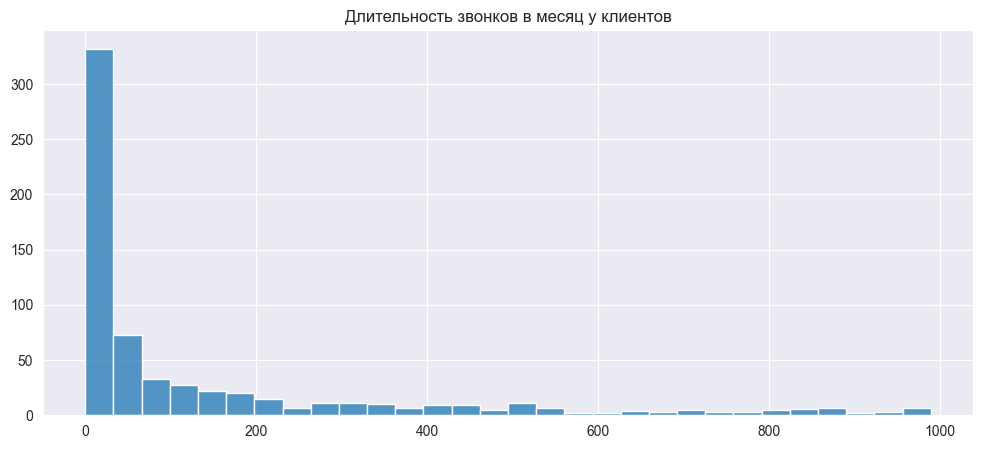

In [55]:
create_histplot(duration_stat.query('total_call_duration_min<1000'), 
                x='total_call_duration_min', 
                bins=30, 
                title='Длительность звонков в месяц у клиентов', 
                xlabel='', 
                ylabel='', 
                figsize=(12, 5))

В распределении длительности звонков, как и в распределении количества, много выбросов. Средняя месячная длительность звонков клиента равна 948 минут, а медианная - 59 минут. Максимальная месячная длительность звонков почти 73 тысячи минут, также есть клиенты с нулевой длительностью.

### 2.3.2. Длительность звонков на разных тарифах

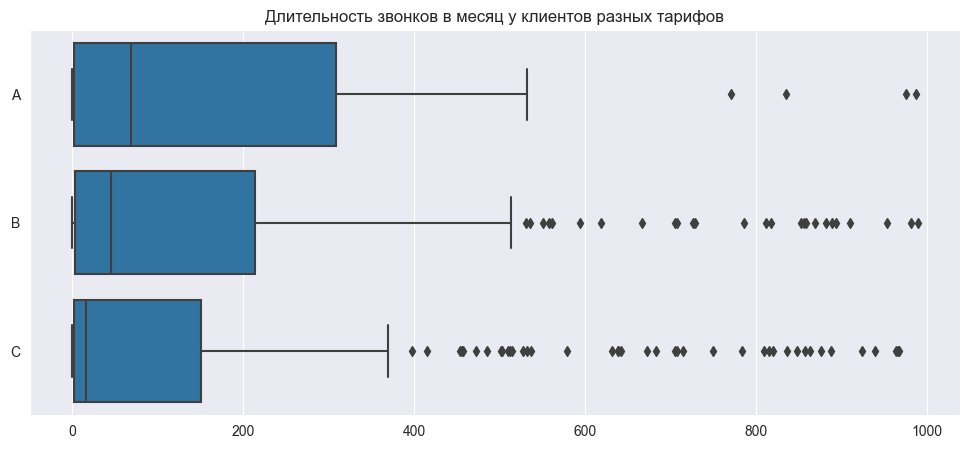

In [56]:
create_boxplots(duration_stat.query('total_call_duration_min<1000'), 
                x='total_call_duration_min', 
                y='tariff_plan', 
                order=['A', 'B', 'C'],
                title='Длительность звонков в месяц у клиентов разных тарифов', 
                xlabel='', 
                ylabel='', 
                figsize=(12, 5))

На тарифе A клиенты в среднем наговаривают 3390 минут в месяц, медиана равна 172 минуты. На тарифе B средняя месяная длительность 759 минут, медианная 87 минут. На тарифе C средняя месяная длительность 550 минут, медианная 39 минут.

Клиенты тарифа A разговаривают дольше, чем клиенты тарифов B и C, это согласуется и с данными по количеству звонков.

### 2.3.3. Длительность внутренних и внешних звонков

In [57]:
internal_duration_stat = get_stat(data[data['internal'].notna()],
                                  ['user_id', 'month', 'internal'],
                                  'total_call_duration_min',
                                  'sum')

internal_duration_stat['internal'] = (
    internal_duration_stat['internal'].astype(bool)
    .replace({True: 'Internal',
              False: 'External'})
)

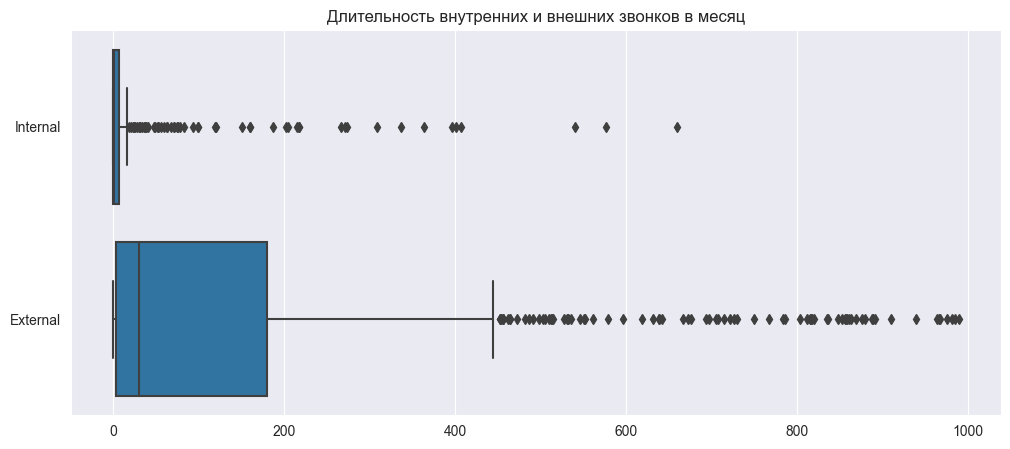

In [58]:
create_boxplots(internal_duration_stat.query('total_call_duration_min<1000'), 
                x='total_call_duration_min', 
                y='internal', 
                title='Длительность внутренних и внешних звонков в месяц', 
                xlabel='', 
                ylabel='', 
                figsize=(12, 5))

По внутренним звонкам средняя длительность составляет 36 минут в месяц, медианная всего 0.91 минуты. По внешним звонкам средняя длительность 934 минуты в месяц, а медианная 58 минуты.

### 2.3.4. Длительность входящих и исходящих звонков за месяц

In [59]:
direction_duration_stat = get_stat(data,
                                   ['user_id', 'month', 'direction'],
                                   'total_call_duration_min',
                                   'sum')

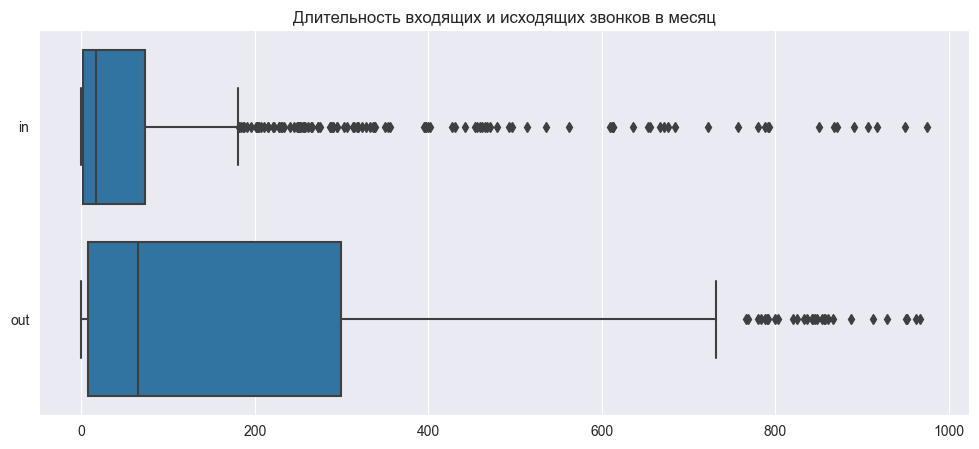

In [60]:
create_boxplots(direction_duration_stat.query('total_call_duration_min<1000'), 
                x='total_call_duration_min', 
                y='direction', 
                title='Длительность входящих и исходящих звонков в месяц', 
                xlabel='', 
                ylabel='', 
                figsize=(12, 5))

Средняя месячная длительность входящих звонков составляет 258 минут, медианная 21 минута. По исходящим звонкам средняя длительность 1066 миунт в месяц, медианная 127 минут в месяц.

### 2.3.6. По месяцам

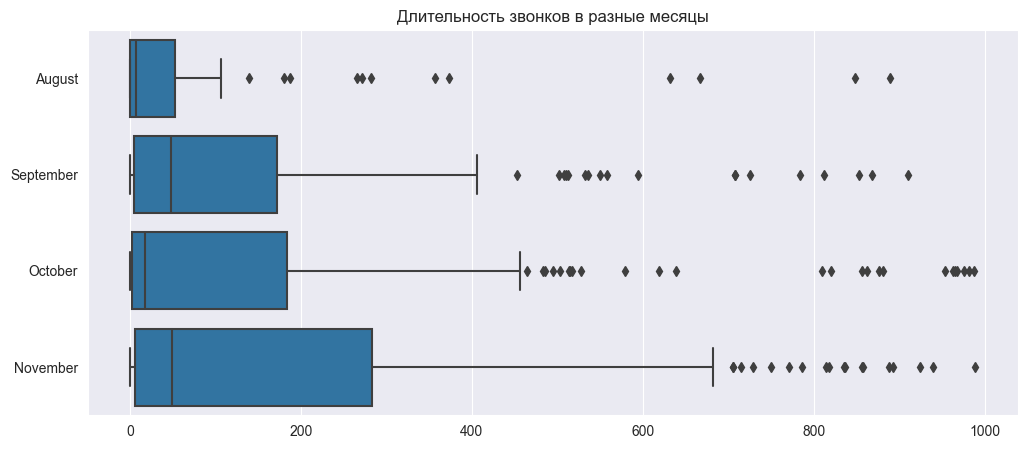

In [61]:
create_boxplots(duration_stat.query('total_call_duration_min<1000'), 
                x='total_call_duration_min', 
                y='month_name', 
                order=['August', 'September', 'October', 'November'],
                title='Длительность звонков в разные месяцы', 
                xlabel='', 
                ylabel='', 
                figsize=(12, 5))

Самая большая длительность звонков набежала за ноябрь (медиана 102 минуты), меньше всего за август (медиана 8 минут).

## 2.4. Анализ количества операторов

Здесь мы агрегируем число операторов за месяц и посмотрим на распределение в целом и в разрезах:
- тарифов
- месяцев

In [62]:
operators_stat = get_stat(data,
                          ['user_id', 'month_name', 'tariff_plan'],
                          'operator_id',
                          pd.Series.nunique)

operators_stat.rename(columns={'operator_id': 'operators_count'},
                     inplace=True)

operators_stat['operators_count'] = operators_stat['operators_count'].astype(int)

operators_stat['operators_count'].describe()

count    788.000000
mean       2.677665
std        4.325118
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       48.000000
Name: operators_count, dtype: float64

### 2.4.1. Общая статистика

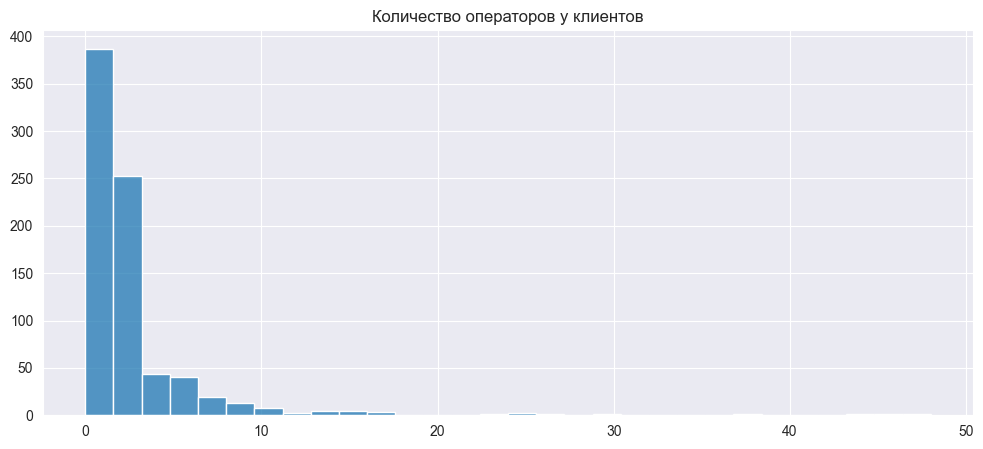

In [63]:
create_histplot(operators_stat, 
                x='operators_count', 
                bins=30, 
                title='Количество операторов у клиентов', 
                xlabel='', 
                ylabel='', 
                figsize=(12, 5))

Среднее количество операторов у клиента равно 3, медианное 2. Есть клиенты, у которых за месяц не работал ни один оператор, а есть крупные клиенты с 48 операторами.

### 2.4.2. Статистика по тарифам

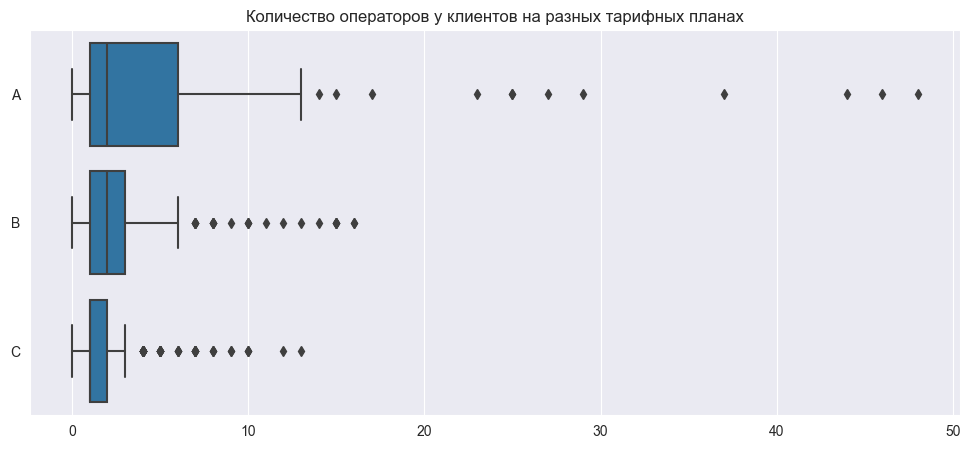

In [64]:
create_boxplots(operators_stat, 
                x='operators_count', 
                y='tariff_plan',
                order=['A', 'B', 'C'],
                title='Количество операторов у клиентов на разных тарифных планах', 
                xlabel='', 
                ylabel='', 
                figsize=(12, 5))

На тарифе A у клиентов в среднем 6 операторов в месяц (медиана 2 оператора), на тарифе B в среднем 3 оператора в месяц (медиана 2 оператора), на тарифе C в среднем 2 оператора в месяц (медиана 1 оператор).

Если не считать крупных клиентов, у которых очень много операторов (в основном это клиенты тарифа А), количество операторов в месяц у клиентов разных тарифов не сильно отличается.

### 2.4.3. Статистика по месяцам

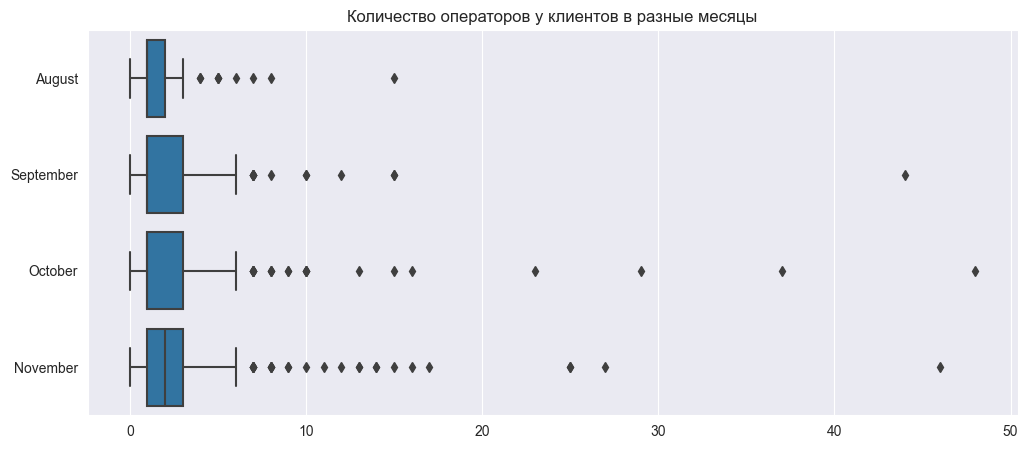

In [65]:
create_boxplots(operators_stat, 
                x='operators_count', 
                y='month_name', 
                order=['August', 'September', 'October', 'November'],
                title='Количество операторов у клиентов в разные месяцы', 
                xlabel='', 
                ylabel='', 
                figsize=(12, 5))

За август, сентябрь, октябрь, ноябрь среднее количество операторов колеблетсе от 2 до 3, медианное значение от 1 до 2. В целом, зависимости от месяца не наблюдается, распределения очень похожи, разве что в октябре и ноябре больше выбросов. Вероятно, в эти месяцы клиенты набирали дополнительных людей.

## 2.6. Активные клиенты

После проведенного исследовательского анализа мы можем выделить следующие критерии активных клиентов:
- клиент пользуется услугами провайдера минимум 3 месяца за исследуемый период, в том числе в последний месяц периода
- у клиента есть работающие операторы (мы видели, что это не всегда так)
- количество и длительность звонков выше медианных показателей

In [66]:
# Подсчет пользователей, которые пользуются услугами 3 месяца
users_months_count = get_stat(data, 'user_id', 'month', pd.Series.nunique)

users_3months= users_months_count.query('month >= 3')['user_id']

In [67]:
# Выделение пользователей, у которых последняя дата использования услуг - ноябрь
users_last_month = get_stat(data, 'user_id', 'month', 'max')

users_november = users_last_month.query('month == 11')['user_id']

In [68]:
# Подсчет медиан количества и длительности звонков
calls_count_median = calls_stat['calls_count'].median()
total_call_duration_median = duration_stat['total_call_duration_min'].median()

users_median_calls = (
    calls_stat.query('calls_count >= @calls_count_median')['user_id']
    .unique()
)
users_median_dur = (
    duration_stat.query('total_call_duration_min >= @total_call_duration_median')['user_id']
    .unique()
)

In [69]:
# Пересечение всех найденных пользователей
active_users_ids = np.intersect1d(
    np.intersect1d(
        np.intersect1d(
            users_3months,
            users_median_calls),
        users_median_dur),
    users_november)

In [70]:
print('Количество активных пользователей: {}'.format(len(active_users_ids)))

Количество активных пользователей: 100


In [71]:
print(
    'Доля активных пользователей от общего числа: {}'.format(
        round(
            100 * len(active_users_ids) / data['user_id'].nunique(), 
            2)
    )
)

Доля активных пользователей от общего числа: 32.68


Из всех клиентов 100 будут считаться активными, это 32.68% от общего числа клиентов.

# 3. Анализ расходов

Перейдем к анализу расходов клиентов. Для всех клиентов мы рассчитаем сумму расходов за каждый месяц по каждому из существующих тарифов.

Для активных клиентов мы также определим:
- оптимальный тариф
- подсчитаем разницу между оптимальным и реальным тарифом

На основе расчетов определим, как изменится выручка заказчика.

## 3.1. Расчет затрат клиентов

In [72]:
# Составим датафрейм с тарифной сеткой

tariffs_dict = {
    'tariff_plan': ['A', 'B', 'C'],
    'price_month': [4000, 2000, 1000],
    'incoming_price': [0, 0, 0],
    'outgoing_external_price': [0.3, 0.5, 0.7],
    'outgoing_internal_limit': [2000, 500, 0],
    'outgoing_internal_price': [0.1, 0.15, 0.3],
    'operator_price': [50, 150, 300]
}

tariffs = pd.DataFrame(tariffs_dict)

Агрегируем данные клиентов по месяцам, затем для каждого месяца рассчитаем, во сколько обойдется каждый из тарифов. Данные сохраним в датафреймах.

In [73]:
costs_a = calculate_cost(calls_df=data, tariff_details=tariffs.loc[0, :])
costs_b = calculate_cost(calls_df=data, tariff_details=tariffs.loc[1, :])
costs_c = calculate_cost(calls_df=data, tariff_details=tariffs.loc[2, :])

Объединим получившиеся расчеты в один датафрейм для удобства сравнения.

In [74]:
# Объединяем датафреймы
costs_full = (
    costs_a.merge(costs_b, on=['user_id', 'month'], suffixes=['_A', '_B'])
    .merge(costs_c, on=['user_id', 'month'])
    .merge(clients, on='user_id', suffixes=['', '_actual'])
    .rename(columns={'total_cost': 'total_cost_C'})
)

# Оставим только нужные для сравнения столбцы
costs_full = costs_full[['user_id', 
                         'month', 
                         'total_cost_A', 
                         'total_cost_B', 
                         'total_cost_C',
                         'tariff_plan_actual']]

## 3.2. Определение оптимальных тарифов

In [75]:
# Выбираем среди трех стоимостей наименьшую - оптимальную
costs_full['tariff_plan_optimal'] = (
    costs_full[['total_cost_A', 'total_cost_B', 'total_cost_C']].idxmin(axis='columns')
    .str[-1]
)

costs_full['cost_optimal'] = (
    costs_full[['total_cost_A', 'total_cost_B', 'total_cost_C']].min(axis='columns')
)

# Добавляем флаг того, совпадает ли реальный тарифный план с оптимальным
costs_full['plans_match'] = (
    costs_full['tariff_plan_actual'] == costs_full['tariff_plan_optimal']
)

## 3.3. Анализ переплат активных клиентов

Для активных клиентов можем подсчитать:
- сколько раз его реальный тариф совпадал с оптимальным
- насколько много клиент переплачивает

In [76]:
users_match_plan_count = get_stat(costs_full.query('user_id in @active_users_ids'), 
                                  'user_id', 
                                  'plans_match', 
                                  'mean')

users_match_plan_count['plans_match'] = round(100 * users_match_plan_count['plans_match'], 2)

users_match_plan_count['plans_match'].value_counts()

plans_match
0.00      49
100.00    35
66.67      8
75.00      3
50.00      2
33.33      2
25.00      1
Name: count, dtype: int64

Видим, что многие активные клиенты дейстивительно переплачивают: у 49 оптимальный тариф не совпал с реальным ни разу за весь период. 

При этом также 35 клиентов получили 100% совпадение: все месяцы, что они работают, они используют оптимальные для себя условия.

Добавим столбец с ценой, которую клиент заплатит в реальности в соответствии со своим тарифом, и подсчитаем разницу.

In [77]:
costs_full['cost_actual'] = 0

costs_full.loc[costs_full['tariff_plan_actual'] == 'A', 
               'cost_actual'] = costs_full['total_cost_A']
costs_full.loc[costs_full['tariff_plan_actual'] == 'B', 
               'cost_actual'] = costs_full['total_cost_B']
costs_full.loc[costs_full['tariff_plan_actual'] == 'C', 
               'cost_actual'] = costs_full['total_cost_C']

costs_full['overpaid'] = costs_full['cost_actual'] - costs_full['cost_optimal']

In [78]:
costs_full.query('user_id in @active_users_ids and overpaid > 0')['overpaid'].describe()

count     197.000000
mean      946.122394
std       770.093364
min         5.616667
25%       464.550000
50%       699.996667
75%      1000.000000
max      3000.000000
Name: overpaid, dtype: float64

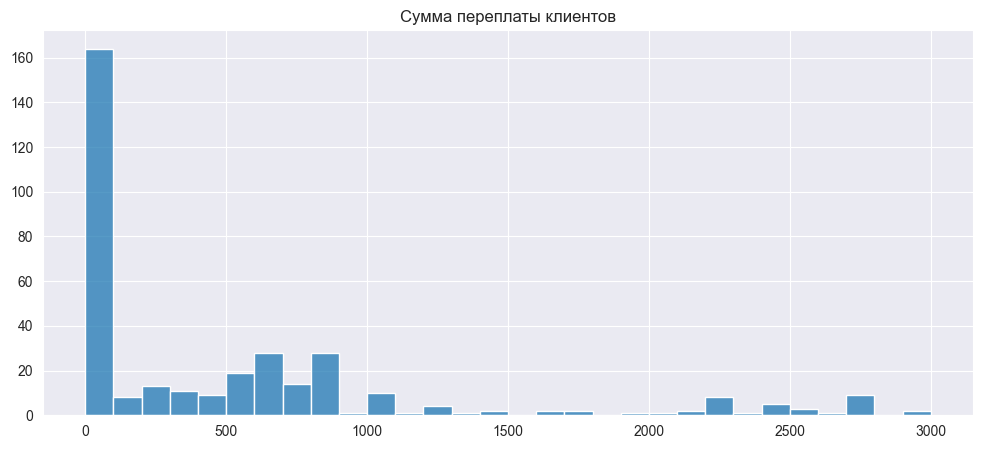

In [79]:
create_histplot(costs_full.query('user_id in @active_users_ids'), 
                x='overpaid', 
                bins=30, 
                title='Сумма переплаты клиентов', 
                xlabel='', 
                ylabel='', 
                figsize=(12, 5))

Максимальная сумма переплаты клиента составила 3000 рублей, минимальная (не считая нуля) 5 рублей, медианная - 770 рублей. Очевидно, что все клиенты переплачивают по-разному, кто-то довольно существенно, а кто-то совсем чуть-чуть. Это необходимо помнить, если мы будем предлагать клиентам переход. Возможно, в случаях когда переплата мала или редка, лучше оставить клиентов как есть.

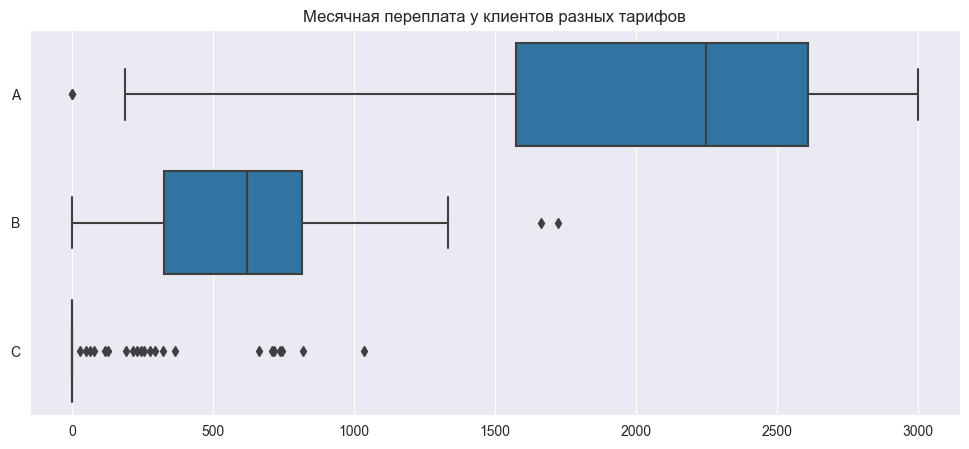

In [80]:
create_boxplots(costs_full.query('user_id in @active_users_ids'), 
                x='overpaid', 
                y='tariff_plan_actual', 
                order=['A', 'B', 'C'],
                title='Месячная переплата у клиентов разных тарифов', 
                xlabel='', 
                ylabel='', 
                figsize=(12, 5))

В разбивке по тарифам видно, что клиенты тарифа A переплачивают значительно больше, чем клиенты тарифов B и C.

# 4. Анализ выручки

На основе расчетов из предыдущего пункта, мы можем посчитать, как изменится выручка заказчика, если клиенты примут решение об изменении тарифа.

Также попробуем найти пути оптимизации потерь выручки.

## 4.1. Подсчет текущей выручки

Для подсчета текущей выручки мы сложим реальные затраты всех клиентов: активных и неактивных. Выручку будем считать за последние три месяца.

In [81]:
revenue_actual = round(costs_full.query('month > 8')['cost_actual'].sum(), 2)

print('Текущая выручка за 3 месяца составит {} рублей'.format(revenue_actual))

Текущая выручка за 3 месяца составит 1786275.9 рублей


## 4.2. Подсчет потенциальной выручки (после перехода клиентов)

Здесь мы для подсчета выручки с активных клиентов возьмем показатель оптимальных затрат (тех, что будут после перехода на новый тариф), а для подсчета выручки с неактивных клиентов возьмем реальные их затраты.

In [82]:
revenue_basic = (
    round(costs_full.query('month > 8 and user_id not in @active_users_ids')['cost_actual']
          .sum(), 2)
)

revenue_transfered = (
    round(costs_full.query('month > 8 and user_id in @active_users_ids')['cost_optimal'])
    .sum()
)

revenue_opt = revenue_basic + revenue_transfered

print('Потенциальная выручка за 3 месяца составит {} рублей'.format(revenue_opt))

Потенциальная выручка за 3 месяца составит 1633827.4300000002 рублей


In [83]:
revenue_loss = round(abs(revenue_opt - revenue_actual), 2)

print('Выручка упадет на {} рублей'.format(revenue_loss))

Выручка упадет на 152448.47 рублей


Видим, что после перехода выручка за три месяца упадет на 152 тысячи рублей. 

## 4.3. Оптимизация потерь выручки

Если все клиенты перейдут на оптимальные для себя тарифы, то провайдер потеряет 155 тысяч рублей выручки.

Так как мы помним, что есть клиенты, которые переплачивают редко или немного, то мы можем не переводить их на другие тарифы. Разница для них будет незначительна, и не подтолкнет их к уходу к конкурентам.

Посмотрим, как изменится потеря выручки в случае, если лишь часть активных клиентов перейдет на другие условия. Попробуем два подхода:
- перевод клиентов на новый тариф только если они переплачивают более чем в 50% случаев
- перевод клиентов на новый тариф только если они хоть раз переплачивали сумму выше медианной

А затем сравним показатели выручки.

In [84]:
users_to_transfer_1 = users_match_plan_count.query('plans_match < 50')['user_id']

overpay_median = (
    costs_full.query('user_id in @active_users_ids and overpaid > 0')['overpaid']
    .median()
)

users_to_transfer_2 = (
    costs_full.query('overpaid > @overpay_median and user_id in @active_users_ids')['user_id']
    .unique()
)

In [85]:
len(users_to_transfer_1), len(users_to_transfer_2) 

(52, 42)

С первым подходом мы затронем 54 пользователей, а со вторым - 42.

### 4.3.1. Перевод клиентов, переплачивающих часто (больше, чем в половине случаев)

In [86]:
revenue_basic = (
    round(costs_full.query('month > 8 and user_id not in @users_to_transfer_1')['cost_actual']
          .sum(), 2)
)

revenue_transfered = (
    round(costs_full.query('month > 8 and user_id in @users_to_transfer_1')['cost_optimal'])
    .sum()
)

revenue_opt1 = revenue_basic + revenue_transfered

print('Потенциальная выручка за 3 месяца составит {} рублей'.format(revenue_opt1))

Потенциальная выручка за 3 месяца составит 1638846.63 рублей


### 4.3.2. Перевод клиентов, переплачивающих много (больше медианного значения)

In [87]:
revenue_basic = (
    round(costs_full.query('month > 8 and user_id not in @users_to_transfer_2')['cost_actual']
          .sum(), 2)
)

revenue_transfered = (
    round(costs_full.query('month > 8 and user_id in @users_to_transfer_2')['cost_optimal'])
    .sum()
)

revenue_opt2 = revenue_basic + revenue_transfered

print('Потенциальная выручка за 3 месяца составит {} рублей'.format(revenue_opt2))

Потенциальная выручка за 3 месяца составит 1651475.63 рублей


В обоих вариантах мы немного сокращаем потери выручки.

## 4.4. Сравнение показателей выручки

Соберем все полученные показатели выручки в один датафрейм и сравним их.

In [88]:
revenue_dict = {'actual': [revenue_actual, 
                           revenue_actual-revenue_actual,
                           round(100*(revenue_actual-revenue_actual)/revenue_actual, 
                                 2)],
                'optimal_full': [revenue_opt, 
                                 revenue_opt-revenue_actual,
                                 round(100*(revenue_opt-revenue_actual)/revenue_actual, 
                                       2)],
                'optimal_by_months': [revenue_opt1, 
                                      revenue_opt1-revenue_actual,
                                      round(100*(revenue_opt1-revenue_actual)/revenue_actual, 
                                            2)],
                'optimal_by_overpay': [revenue_opt2, 
                                       revenue_opt2-revenue_actual,
                                       round(100*(revenue_opt2-revenue_actual)/revenue_actual,
                                             2)]}

revenue = pd.DataFrame(revenue_dict, index=['value', 'loss_abs', 'loss_pct'])

revenue

,actual,optimal_full,optimal_by_months,optimal_by_overpay
value,1786275.9,1633827.43,1638846.63,1651475.63
loss_abs,0.0,-152448.47,-147429.27,-134800.27
loss_pct,0.0,-8.53,-8.25,-7.55


Если мы не будем никак оптимизировать затраты клиентов, то наша базовая выручка за три месяца составит 1.79 млн.рублей.

Если мы переведем на оптимальные тарифы всех активных клиентов, то наша выручка за три месяца составит 1.63 млн.рублей, на 8.53% меньше базовой.

Если мы переведем на оптимальные тарифы только тех клиентов, которые переплачивали в 50% всего периода работы или чаще, то наша выручка за три месяца составит 1.64 млн.рублей, на 8.25% меньше базовой.

Если мы переведем на оптимальные тарифы пользователей, которые переплачивали много, выше медианного показателя, то наша выручка за три месяца составит 1.65 млн.рублей, на 7.55% меньше от базовой.

Если сравнивать вышеперечисленные подходы, то последний кажется более выигрышным для нас.

# 5. Выводы и предложения

В ходе проекта были исследованы данные об использовании услуг телефонии за период со 2 августа до 28 ноября 2019 года.

Согласно данным самый популярный у клиентов тариф - это тариф C, им пользуется 161 клиент. Второй по популярности тариф B, им пользуются 112 человек. Тариф A на последнем месте, им пользуются 33 клиента.

Профили пользователей и их статистика использования услуг отличаются по тарифам. Пользователи тарифа A в среднем (в качестве среднего здесь используем медианное значение) совершают звонков 150 в месяц, пользователи тарифа B - 96 звонков в месяц. Пользователи тарифа C - 38 звонков в месяц.

Медианная месячная длительность звонков на тарифе A равна 172 минуты, на тарифе B - 87 минуты, на тарифе C - 39 минут.

Таким образом, клиенты тарифа A пользуются услугами гораздо активнее клиентов других тарифов.

После исследовательского анализа данных были сформированы критерии активных клиентов:
- клиент пользуется услугами провайдера минимум 3 месяца за исследуемый период, в том числе последний месяц
- у клиента есть работающие операторы (мы видели, что это не всегда так)
- количество и длительность звонков выше медианных показателей

По этим критериям мы получили выборку из 100 активных клиентов. Для них был проведен анализ оптимальности их затрат. По итогам выяснилось, что клиенты используют тарифную сетку неоптимально:
- 49 клиентов (почти половина всех активных) переплачивал каждый месяц использования услуг
- медианная сумма переплаты составила 770 рублей в месяц

После расчета оптимальных затрат была также пересчитана суммарная выручка провайдера за 3 месяца:
- посчитана базовая выручка (в случае, когда клиенты остаются на своих текущих тарифах)
- посчитана выручка на случай, если все активные клиенты сменят тариф на оптимальный
- посчитана выручка на случай, если только те активные клиенты, которые переплачивают часто, сменят тариф на оптимальный
- посчитана выручка на случай, если только те активные клиенты, которые переплачивают много, сменят тариф на оптимальный

В результате сравнения этих четырех показателей, получилась такая таблица:

||Показатель, руб.|Потеря, руб.|Потеря, % от Базовой выручки|
|---|---|---|---|
|Базовая выручка|1.79 млн.|0|0|
|Выручка, полный перевод|1.63 млн.|155 тыс.|8.53|
|Выручка, перевод на основе частоты переплат|1.64 млн.|150 тыс.|8.25|
|**Выручка, перевод на основе суммы переплат**|**1.65 млн.**|**136 тыс.**|**7.55**|

Если сравнивать вышеперечисленные подходы, то последний кажется более выигрышным для нас.